In [53]:
# -------------------------------------------------------- Imports --------------------------------------------------------
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape
from IPython.display import Image
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

In [ ]:
# -------------------------------------------------------- Load Data --------------------------------------------------------
energy = load_data('./')[['load']]
energy.head(10)

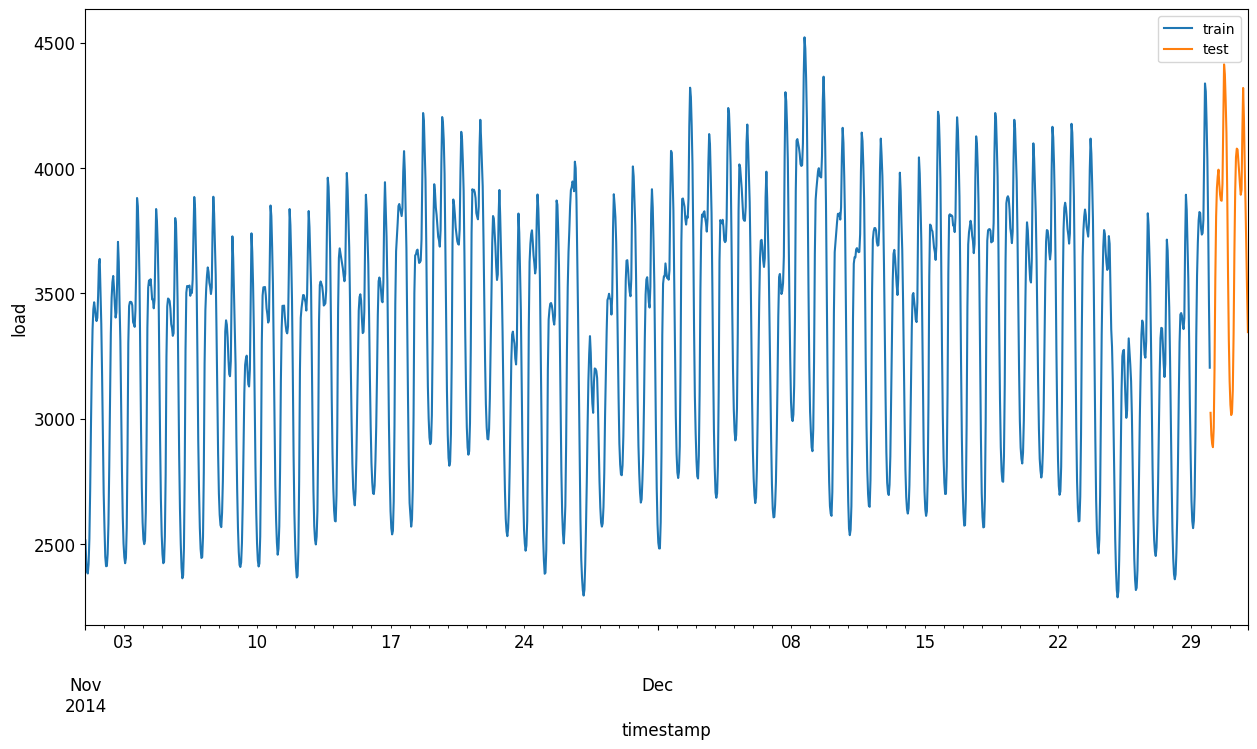

In [56]:
# -------------------------------------------------------- Split Data --------------------------------------------------------
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

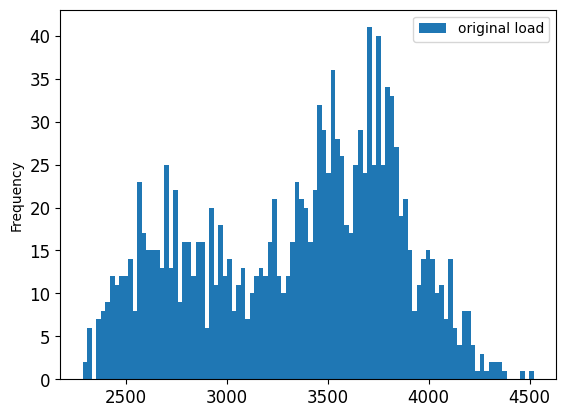

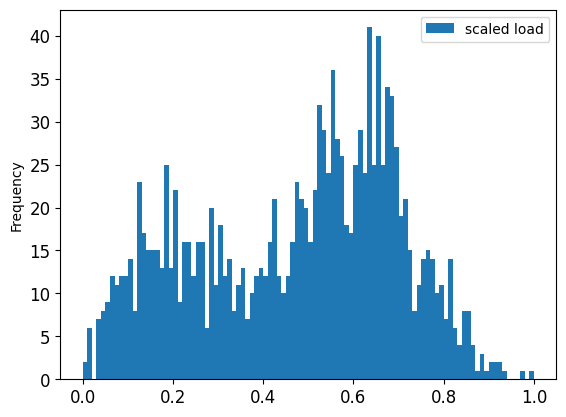

In [59]:
# -------------------------------------------------------- Scale Data  --------------------------------------------------------
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
test['load'] = scaler.transform(test)
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [ ]:
# -------------------------------------------------------- Model  --------------------------------------------------------
HORIZON = 3
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)
model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

In [ ]:
# -------------------------------------------------------- Evaluate  --------------------------------------------------------
# ---- Walk Forward Validation ----
test_shifted = test.copy()
for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')
    
test_shifted = test_shifted.dropna(how='any')

In [65]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

# let's user simpler model for demonstration
order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 03:00:00
4 : predicted = [0.28 0.32 0.42] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
2014-12-30 05:00:00
6 : predicted = [0.4  0.55 0.67] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
2014-12-30 06:00:00
7 : predicted = [0.57 0.68 0.75] expected = [0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
2014-12-30 07:00:00
8 : predicted = [0.68 0.75 0.8 ] expected = [0.6799462846911368, 0.7309758281110115, 0.75111906893

In [ ]:
# ---- Walk Forward Validation - Compare Predictions 2 Load ----
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

In [ ]:
# ---- MAPE ----
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


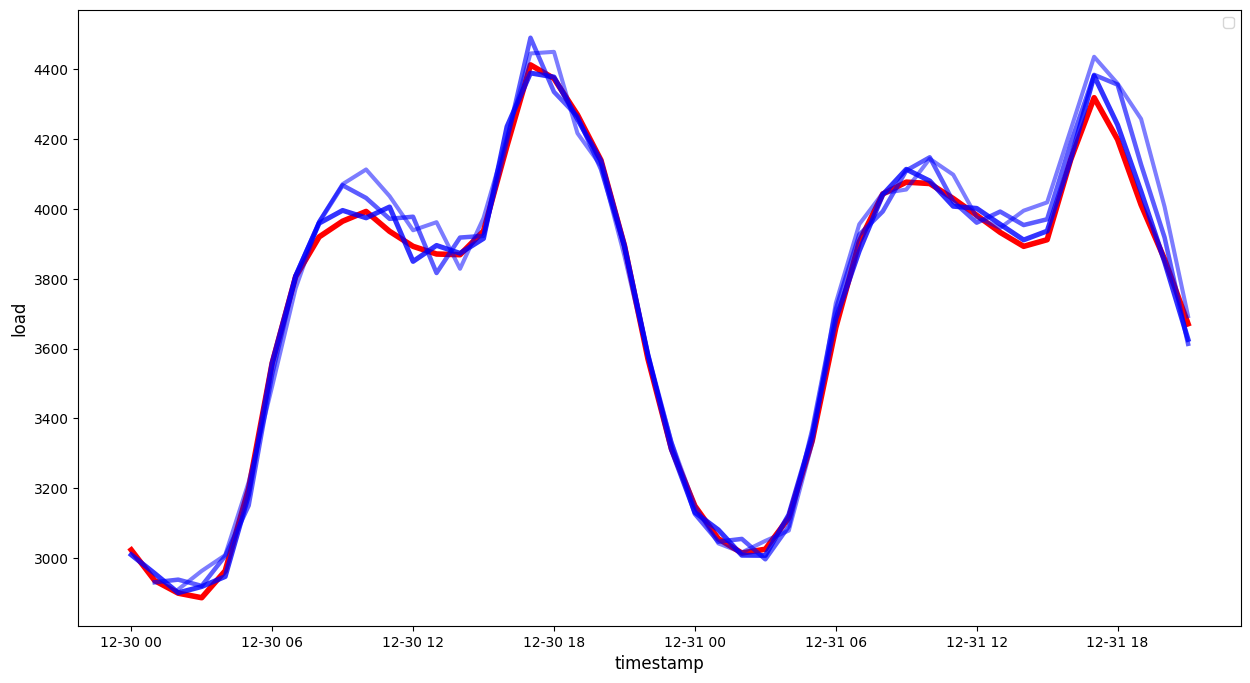

In [70]:
# -------------------------------------------------------- Visualize  --------------------------------------------------------
if HORIZON == 1:
    # Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))
else:
    # Plotting multi-step forecast
    plot_df = eval_df[eval_df['h'] == 't+1'][['timestamp', 'actual']]
    for t in range(1, HORIZON + 1):
        plot_df['t+' + str(t)] = eval_df[eval_df['h'] == 't+' + str(t)]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)  # Create the subplot

    ax.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    
    for t in range(1, HORIZON + 1):
        x = plot_df['timestamp'][(t - 1):]
        y = plot_df['t+' + str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4 * math.pow(0.9, t), alpha=math.pow(0.8, t))

    ax.legend(loc='best')

    plt.xlabel('timestamp', fontsize=12)
    plt.ylabel('load', fontsize=12)
    plt.show()